## **Multi-Scenario Video and Audio Synchronization and Segmentation**
#### *Author: Hamza Nalbantoğlu$^{1,2}$, Šárka Kadavá$^{1}$*  
#### *Affiliation: **1 -** Leibniz-Centre General Linguistics (ZAS); **2 -** University of Potsdam (UP)*  
#### *Contact: nalbantogluhamza@gmail.com*  
---

## **Overview**
This module provides a **flexible pipeline for aligning video and audio recordings of the same event**, recorded separate devices. The script is designed to handle various cases, offering a versatile approach to synchronization and segmentation.

We will use [**Shign**](https://github.com/KnurpsBram/shign)—a Python package designed for precise audio alignment—to synchronize two audio tracks (one from the video and one from the audio). Instead of relying on manual adjustments, Shign detects timing mismatches between the two audio streams and computes the necessary **time shift** to align them.

This script provides an **automated and accurate approach** to video-audio alignment, making it particularly useful for behavioural data analysis, experimental research, and other applications requiring precise synchronization.
  
### **You Can Use This Script in:**  
- **(1) Video-Audio Alignment:**  
  - You have a **video (MP4 or AVI) and a separate audio (WAV or raw as CSV)** recording and want to align them.  
  - The script allows for **audio extraction** from the video and **conversion** (if needed) of raw CSV audio to WAV before alignment.
- **(2) Aligning Two Videos Based on Their Audio:**  
  - You have **two videos of the same event** recorded on separate devices and want to align them.  
  - The script can extract the audio from both videos, align them using **Shign**, and trim first video to match the other.
- **(3) Audio-Only Alignment (No Video Required):**  
  - You have **two audio files** (e.g., recorded separately with different devices) and want to align them.  
  - This can involve either **pre-extracted audio files from two videos** or two independent audio recordings.
  - The script allows for the conversion of raw audio recordings to WAV files, if needed.  
- **(4) LSL-Based Trial Segmentation (Optional, Not Required for Alignment):**  
  - If you recorded timestamps in **Lab Streaming Layer (LSL)** (e.g., via a button press) during the audio recording, this script can compute **trial start and end times** for the video.  
  - It finds the **corresponding video timestamps (seconds) based on the LSL-synced audio timeline**, allowing segmentation of the video into trials (without audio by default, could be adjusted in the script).  
- **(5) Overlaying LSL-Audio onto the Segmented Videos (Optional, Not Required for Alignment):**  
  - After alignment, you can **overlay high-quality LSL audio streams** onto each segmented trial video.  
  - Useful for **verification** (ensuring perfect synchronization) or **improving audio quality**.  
  
---  
  
### **Supported Input Types**  
- **Video files with an embedded audio** (`.MP4` or `.AVI`) or **audio files** (`.WAV` or `.CSV`). 
  
---  
  
## **Workflow Overview**  
This script provides three different ways to align video and audio recordings of the same event.  
Follow the option that matches your data:  

### **Option 1: Video-Audio Alignment**  
**Use this if you have** a **video file (.MP4 or .AVI)** and a **separate audio recording (.WAV or .CSV)** that need to be synchronized.  
- Extracts audio from the video.  
- Converts raw CSV audio to WAV (if necessary).  
- Aligns the extracted video audio with the external audio using **Shign**.  
- Trims the video to match the aligned audio.  
📌 **Navigate to Option 1 and run the code chunks there.**  

### **Option 2: Aligning Two Videos Using Their Audio**  
**Use this if you have two video files** (.MP4 or .AVI) **of the same event** recorded on separate devices.  
- Extracts audio from both videos.  
- Aligns the first video’s audio to the second video’s audio.  
- Trims the first video to match the second.  
📌 **Navigate to Option 1 and run the code chunks there.**  

### **Option 3: Audio-Only Alignment (No Video Needed)**  
**Use this if you have two separate audio files** (.WAV or .CSV) **that need to be aligned**.  
- Converts raw .CSV audio to .WAV (if necessary).  
- Aligns both audio tracks using **Shign**.  
📌 **Navigate to Option 3 and run the code chunks there.**  

### **Next Steps: LSL-Based Trial Segmentation & Audio Overlay (Optional)**  
If you used **Option 1 (Video-Audio Alignment)** and your external audio was recorded with **Lab Streaming Layer (LSL)**, you can:  
✅ **Segment the aligned video into trials** using LSL timestamps.  
✅ **Overlay high-quality LSL audio** onto trial videos.  
**These two steps are optional and only relevant if you used LSL for audio recording.**  
If you just need alignment, you can skip them. 

---
## **GitHub Repository & Installation**
To reproduce this notebook, follow these steps:

```bash
# 1 - Clone the Repository
git clone https://github.com/hamzanalbantoglu/flexible_audio_video_sync.git
cd flexible_audio_video_sync

# 2 - Create a Conda Environment (Recommended)
conda create --name audio_video_sync python=3.12
conda activate audio_video_sync

# 3 - Install Dependencies
pip install -r requirements.txt

# 4 - Add Conda Environment to Jupyter Notebook
pip install ipykernel
python -m ipykernel install --user --name=audio_video_sync --display-name "Python (audio_video_sync)"

# 5 - Run the Jupyter Notebook
jupyter notebook
```
---
## **Citation**
If you use this module in your research or project, please consider citing it:

Nalbantoğlu, H., & Kadavá, Š. (2024). Aligning and Synchronizing Multi-Source Video and Audio Recordings. [the day you viewed the site]. Retrieved from: xxx

In [1]:
# Imports
import os
import re
import time
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
import librosa
import subprocess
from IPython.display import Audio, HTML
from shign.shign import ms_to_samples, shift_align
from scipy.io.wavfile import write

## Loading Input Data & Defining Output Paths

Before processing, we first specify the paths to the first input and the second input. These will serve as our primary input files to synchronize. 

Please make sure the first input file always includes the audio or video file **to be trimmed and aligned** to the second one. The second input will serve as a **reference** in all scenarios and will **not be modified**.

Additionally, we define paths for storing processed audio files and aligned outputs at different stages of the workflow. The following chunk automatically selects the input from the respective folders. Please ensure the intended input files are placed in the correct folders.

In [2]:
# (DON'T MODIFY THIS CHUNK PLEASE!)

# Input paths (if you have a video and an audio, video file should be placed in the FIRST ONE):
input1_folder = "input1/"                                   # Input folder 1
input2_folder = "input2/"                                   # Input folder 2

# Output paths:
audio_1 = "outputs/audio_1.wav"                             # First audio to align with Shign (extracted from video or converted from raw audio)
audio_2 = "outputs/audio_2.wav"                             # Second audio to align with Shign (extracted from video or converted from raw audio)
audio_1_aligned = "outputs/audio_1_aligned.wav"             # First audio after Shign alignment with the second audio
video_1_aligned = "outputs/video_1_aligned.mp4"             # Video in input1, trimmed for alignment (OPTIONAL OUTPUT)

# Function to find and select input1 and input2 automatically:
valid_extensions = [".mp4", ".avi", ".wav", ".csv"]
def get_input_file(folder):
    files = [f for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in valid_extensions] 
    if len(files) == 0:
        raise ValueError(f"No valid input files found in {folder}. Must be one of: {valid_extensions}")
    return os.path.join(folder, files[0])

input1 = get_input_file(input1_folder)                      # Can be video (.MP4, .AVI) or audio (.WAV, .CSV)
input2 = get_input_file(input2_folder)                      # Can be video (.MP4, .AVI) or audio (.WAV, .CSV)

# OPTION 1 - VIDEO-AUDIO ALIGNMENT

Step 1 assumes you have a **video (MP4) and a separate audio (WAV or raw as CSV)** recording of the same event and want to align them. After executing all the code chunks in this step, you will have the following files in the ```outputs/``` folder:

- **audio_1.wav**: extracted audio from the video input
- **audio_2.wav**: audio input (converted to .WAV if it is a .CSV file) - Optional output
- **audio_1_aligned.wav**: audio_1 after Shign alignment with audio_2
- **video_1_aligned.mp4**: video aligned to the audio (trimmed)

## Step 1.1 - Inspecting the Input Video for Audio Sample Rate

The **sample rate** of the input video's audio track is a crucial information for two reasons:

- To extract the audio while preserving its original quality.
- To align it with the input audio using Shign, which requires both audio tracks to have the same sample rate for better accuracy.

FFmpeg retrieves metadata for both the video and audio streams. From the output, we can confirm that the audio sample rate is **44.1 kHz** (44100 Hz), which will be used in the next steps.

In [4]:
# Inspecting the metadata of the video using FFmpeg:
result = subprocess.run(
    ["ffmpeg",
     "-hide_banner",
     "-i", input1],
    capture_output=True,
    text=True
)

print(result.stderr)

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'input1/external_video.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2mp41
    encoder         : Lavf61.9.100
  Duration: 00:35:00.03, start: 0.000000, bitrate: 7256 kb/s
  Stream #0:0[0x1](und): Video: mpeg4 (Simple Profile) (mp4v / 0x7634706D), yuv420p, 1920x1080 [SAR 1:1 DAR 16:9], 7177 kb/s, 60 fps, 60 tbr, 15360 tbn (default)
    Metadata:
      handler_name    : VideoHandler
      vendor_id       : [0][0][0][0]
  Stream #0:1[0x2](und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, mono, fltp, 69 kb/s (default)
    Metadata:
      handler_name    : SoundHandler
      vendor_id       : [0][0][0][0]
At least one output file must be specified



## Step 1.2 - Extracting the Audio from the Video

We can extract the audio track from the video input using FFmpeg, making sure that it is formatted correctly for aligning with the input audio later.

In [5]:
input1_sr = "44100" # (checked in the previous step, ADJUST CORRECTLY for your video)

# Extracting audio from the video:
subprocess.run([
    "ffmpeg",              
    "-i", input1,               # Input video  
    "-vn",                      # Remove video stream, keep only audio stream
    "-acodec", "pcm_s16le",     # Use PCM 16-bit encoding
    "-ar", input1_sr,           # Set sample rate
    "-ac", "1",                 # Convert stereo to mono for consistency with the input audio
    audio_1       
], check=True)

CompletedProcess(args=['ffmpeg', '-i', 'input1/external_video.mp4', '-vn', '-acodec', 'pcm_s16le', '-ar', '44100', '-ac', '1', 'outputs/audio_1.wav'], returncode=0)

In [6]:
# If input2 is already a .WAV file, we can use it directly. Otherwise, please use the next step before step 1.4.
if input2.lower().endswith(".wav"):
    audio_2 = input2

## Step 1.3 - Ensuring Correct Audio Format (.WAV) Before Alignment (CONDITIONAL)

If the input audio is stored as raw sound pressure values in a .CSV file, we need to convert it to a .WAV file with the correct sample rate. Only then, we can use it together with the audio extracted from the video for synchronization.

In the example input2 provided, the audio is in a raw format stored in a .CSV file, which contains:

- **LSL timestamps** (in milliseconds) in the first column.
- **Sound pressure values** in the second column.

We also know that the recording sample rate is **16 kHz** (16000 Hz). Now, we can extract the pressure values and save them as a .WAV file using **SciPy’s** ```write()``` **function**.

In [7]:
# Loading the input audio file and extracting the pressure values:
audio_data = pd.read_csv(input2)
pressure = audio_data["1"].values.astype(np.int16)

# Saving it as a .WAV file with a sample rate of 16 kHz:
sample_rate = 16000
write(audio_2, sample_rate, pressure)

## Step 1.4 - Aligning the Two Audio Tracks Using "shign"

To synchronize the audio_1 (extracted from video) and audio_2, we use the **```shift_align()```** function from the **Shign package**. It compares the two audio tracks using correlation, detects the timing mismatch between them, and align them based on the detected mismatch.

Since the audio_2 has a sample rate of 16 kHz, while the audio_1 is 44.1 kHz, we must first **downsample the audio_1** to the same sample rate before alignment. This is crucial to get more accurate results from the ```shift_align()``` function.

In [8]:
# Loading the audio files:
audio_1, sr_1 = librosa.load(audio_1, sr=None)       # input1 video audio
audio_2, sr_2 = librosa.load(audio_2, sr=None)       # input2 audio

# Downsampling the audio_1 to match the audio_2 sample rate:
audio_1_downsampled = librosa.resample(audio_1, orig_sr=sr_1, target_sr=sr_2)
sr_1_downsampled = sr_2

Before aligning, we can plot both audio waveforms to inspect their initial timing differences:

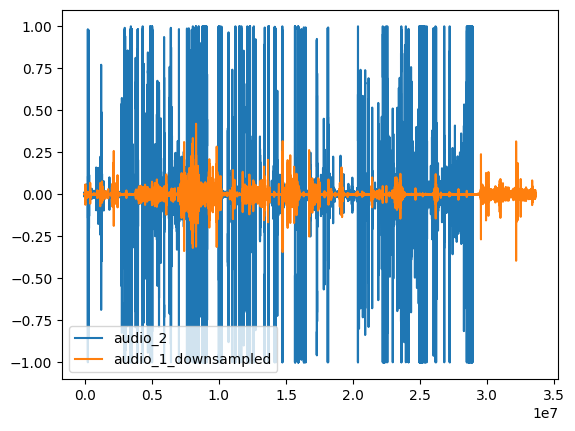

In [9]:
plt.plot(audio_2, label='audio_2')
plt.plot(audio_1_downsampled, label='audio_1_downsampled')
plt.legend(loc='lower left')
plt.show()

Next, we use the modified **```shift_align()```** function from **Shign** to determine the **time shift** (in milliseconds) needed to align the audio_1 with the audio_2.

By default, shift_align() returns the aligned versions of both audio tracks. However, we will also extract **shift_ms**, which tells us how much the video needs to be adjusted to synchronize and align with audio_2.

Key Parameters:
- **```audio_a```** → audio_2 (reference audio).
- **```audio_b```** → audio_1_downsampled (audio to be align).
- **```sr_a```** & **```sr_b```** → Sample rates of both tracks (must match).
- **```align_how```** → **```"pad_and_crop_one_to_match_other"```** ensures that only the second argument (audio_1_downsampled) is adjusted, keeping the audio_2 unchanged.
- **```max_shift_sec```** = 300 → Sets a limit of 300 seconds for possible shifts (can be adjusted if needed).

In [10]:
# Aligning the audio_1_downsampled and audio_2:
_, aligned_audio_1, shift_ms = shift_align(            # saving shift_ms here for later use
    audio_a = audio_2,                                 # reference audio (will remain unchanged)
    audio_b = audio_1_downsampled,     
    sr_a    = sr_2,
    sr_b    = sr_1_downsampled,
    align_how = "pad_and_crop_one_to_match_other",     # only modify the second audio (from the video)
    max_shift_sec = 300
)

# Saving the audio_1_aligned after the synchronization:
write(audio_1_aligned, sr_1_downsampled, aligned_audio_1)

print(f"Mismatch between two audio track is \033[1m{shift_ms/1000} seconds\033[0m.")

Mismatch between two audio track is -65.965 seconds.


---
Negative mismatch time means the second audio (video audio) starts later than the first one (audio_2).

Now, we can plot both audio signals again to verify that the extracted video audio is correctly shifted and aligned with the audio_2.

We can also print the lengths of both audio arrays and play them for further verification.

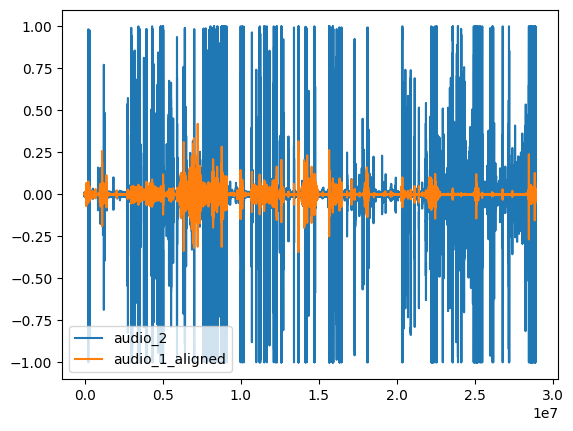

Length of audio_2: 28905579 samples
Length of audio_1_aligned: 28905579 samples

Audio_2:


Audio_1_Aligned:


In [11]:
plt.plot(audio_2, label='audio_2')
plt.plot(aligned_audio_1, label='audio_1_aligned')
plt.legend(loc='lower left')
plt.show()

# Printing the lengths of both audio arrays for verification:
print(f"Length of audio_2: {len(audio_2)} samples")
print(f"Length of audio_1_aligned: {len(aligned_audio_1)} samples\n")

# Play back the two audio to further verify synchronization:
print("\033[1mAudio_2:\033[0m")
audio_2_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_2.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_2_html)

print("\033[1mAudio_1_Aligned:\033[0m")
audio_1_aligned_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_1_aligned.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_1_aligned_html)

## Step 1.5 - Aligning the Video to the Audio

After extracting the audio from the video, we aligned it with the other audio using **Shign**. Since both recordings captured the same event but were not synchronized, ```shign_align()``` function detected their timing mismatch and computed the **"shift_ms"** needed to align them.

Using this precise time shift, we first adjusted the video's audio to match the second audio. Now, we apply the same **"shift_ms"** value to **trim the video** itself, ensuring that it is also perfectly synchronized with the **audio_2**.

To do this, we use **```ms_to_samples()```** from Shign, which converts **milliseconds into audio samples**. This conversion allows us to locate the start and end samples in the audio_1_aligned, which we then use to compute the corresponding **video timestamps (in seconds)** for trimming it.

In [12]:
# Start sample computed from shift_ms using ms_to_samples():
start_sample = ms_to_samples(abs(shift_ms), sr=sr_1_downsampled)
print(f"audio_1_aligned starts at: \033[1m{abs(shift_ms):.2f}\033[0m milliseconds")
print(f"audio_1_aligned starts at: \033[1m{start_sample:.2f}\033[0m sample")

# End sample computed from start sample + total samples:
total_samples = len(aligned_audio_1)
end_sample = start_sample + total_samples
print(f"audio_1_aligned ends at: \033[1m{end_sample:.2f}\033[0m sample\n")

# Converting audio samples to video timestamps (seconds) using the sample rate of the audio:
start_time_sec = start_sample / sr_1_downsampled
end_time_sec = end_sample / sr_1_downsampled
print(f"video_1_aligned starts at: \033[1m{start_time_sec:.2f}\033[0m second")
print(f"video_1_aligned ends at: \033[1m{end_time_sec:.2f}\033[0m second")

audio_1_aligned starts at: 65965.00 milliseconds
audio_1_aligned starts at: 1055440.00 sample
audio_1_aligned ends at: 29961019.00 sample

video_1_aligned starts at: 65.97 second
video_1_aligned ends at: 1872.56 second


---
Once we compute the ```start_time_sec``` and ```end_time_sec``` values, we can now trim the input1 video using **FFmpeg** to align it with the input2 audio.

**This process may take a while depending on the total video duration and your computer's specifications...**

In [13]:
# Trimming and saving the video using FFmpeg:
print(f"Trimming the video from \033[1m{start_time_sec:.2f}s\033[0m to \033[1m{end_time_sec:.2f}s\033[0m...")
total_length_sec = end_time_sec-start_time_sec
minutes, seconds = divmod(total_length_sec, 60)
print(f"video_1_aligned length will be \033[1m{int(minutes)} minutes {int(seconds)} seconds\033[0m...")

# Setting up the FFmpeg command:
command = [
    "ffmpeg",
    "-ss", f"{start_time_sec:.3f}",                    # start time BEFORE -i ensures frame accuracy
    "-i", input1,                                      # input video
    "-to", f"{end_time_sec - start_time_sec:.3f}",     # duration after start
    "-c:v", "libx264",                                 # re-encode video for frame accuracy
    "-c:a", "aac",                     
    "-preset", "fast",                                 # encoding speed optimization
    "-reset_timestamps", "1",                          # reset timestamps after cutting (necessary)
    video_1_aligned                                    # output path for the aligned video
]

# Starting the subprocess:
process = subprocess.Popen(command, stderr=subprocess.PIPE, stdout=subprocess.PIPE, text=True)

# Regular expression to find the time from FFmpeg outputs:
time_pattern = re.compile(r"time=(\d+:\d+:\d+\.\d+)")

start = time.time()  # Recording the start time for estimated time calculations

# Calculating the estimated time left:
try:
    calculating_now = False
    while True:
        line = process.stderr.readline()
        if not line:
            break
        # Find the current time from ffmpeg output:
        match = time_pattern.search(line)
        if match:
            current_time = match.group(1)
            h, m, s = map(float, current_time.split(':')) # hour, minute, seconds
            elapsed_seconds = h * 3600 + m * 60 + s - start_time_sec
            if elapsed_seconds > 30:  # Wait 30s before printing the first estimation
                elapsed_time = time.time() - start
                # Estimated total time:
                estimated_total_time = (elapsed_time / elapsed_seconds) * (end_time_sec - start_time_sec)
                # Estimated time left:
                etl = estimated_total_time - elapsed_time
                # Converting seconds to a more readable format:
                eta_hours = int(etl // 3600)
                eta_minutes = int((etl % 3600) // 60)
                eta_seconds = int(etl % 60)
                # Print and update the estimated time left on the same line:
                print(f"Estimated time remaining: {eta_hours}h {eta_minutes}m {eta_seconds}s", end='\r')
        elif not calculating_now:
            print("Calculating remaining time...", end='\r')
            calculating_now = True
finally:
    process.stderr.close()

print(f"Trimming completed! Aligned video saved in \033[1m{video_1_aligned}\033[0m\n")

# We can now play the aligned_video for verification:
HTML(f"""
<video width="1000" controls>
  <source src="{video_1_aligned}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

Trimming the video from 65.97s to 1872.56s...
video_1_aligned length will be 30 minutes 6 seconds...
Trimming completed! Aligned video saved in outputs/video_1_aligned.mp4



# OPTION 2 - VIDEO-VIDEO ALIGNMENT

Step 2 assumes you have **two videos (MP4, AVI, etc.) of the same event** recorded separately and want to align them based on their extracted audio tracks. After executing all the code chunks in this step, you will have the following files in the ```outputs/``` folder:  
  
- **audio_1.wav**: extracted audio from the first video input  
- **audio_2.wav**: extracted audio from the second video input  
- **audio_1_aligned.wav**: audio_1 after Shign alignment with audio_2  
- **video_1_aligned.mp4**: first video aligned to the second video (trimmed) 

## Step 2.1 - Inspecting the Input Videos for Audio Sample Rates

The **sample rates** of the input videos' audio track are crucial for two reasons:

- To extract the audio while preserving its original quality.
- To align them using Shign, which requires both audio tracks to have the same sample rate for better accuracy.

FFmpeg retrieves metadata for both the video and audio streams in each input video. From the outputs, we can check the audio sample rates to use in the next steps.

In [ ]:
# Inspecting the metadata of the input1 and input2 videos using FFmpeg:
result1 = subprocess.run(
    ["ffmpeg",
     "-hide_banner",
     "-i", input1],
    capture_output=True,
    text=True
)

result2 = subprocess.run(
    ["ffmpeg",
     "-hide_banner",
     "-i", input2],
    capture_output=True,
    text=True
)

print(result1.stderr)
print(result2.stderr)

## Step 2.2 - Extracting the Audio from the Video Inputs

We can extract the audio track from both video inputs using FFmpeg, making sure that it is formatted correctly for aligning later using Shign.

In [ ]:
input1_sr = "44100" # (checked in the previous step, ADJUST CORRECTLY for your video)
input2_sr = "16000" # (checked in the previous step, ADJUST CORRECTLY for your video)

# Extracting audio from the video:
subprocess.run([
    "ffmpeg",              
    "-i", input1,               # Input video  
    "-vn",                      # Remove video stream, keep only audio stream
    "-acodec", "pcm_s16le",     # Use PCM 16-bit encoding
    "-ar", input1_sr,           # Set sample rate to 44.1 kHz (checked earlier, ADJUST CORRECTLY for your video)
    "-ac", "1",                 # Convert stereo to mono for consistency with the input audio
    audio_1       
], check=True)

# Extracting audio from the video:
subprocess.run([
    "ffmpeg",              
    "-i", input2,               # Input video  
    "-vn",                      # Remove video stream, keep only audio stream
    "-acodec", "pcm_s16le",     # Use PCM 16-bit encoding
    "-ar", input2_sr,           # Set sample rate to 44.1 kHz (checked earlier, ADJUST CORRECTLY for your video)
    "-ac", "1",                 # Convert stereo to mono for consistency with the input audio
    audio_2       
], check=True)

## Step 2.3 - Aligning the Two Extracted Audio Tracks Using "shign"

To synchronize the audio_1 (extracted from first video) and audio_2 (extracted from first video), we use the **```shift_align()```** function from the **Shign package**. It compares the two audio tracks using correlation, detects the timing mismatch between them, and align them based on the detected mismatch.

Since the audio_2 has a sample rate of 16 kHz, while the audio_1 is 44.1 kHz, we must first **downsample the audio_1** to the same sample rate before alignment. This is crucial to get more accurate results from the ```shift_align()``` function.

In [ ]:
# Loading the audio files:
audio_1, sr_1 = librosa.load(audio_1, sr=None)       # input1 video audio
audio_2, sr_2 = librosa.load(audio_2, sr=None)       # input2 video audio

# Downsampling the audio_1 to match the audio_2 sample rate:
audio_1_downsampled = librosa.resample(audio_1, orig_sr=sr_1, target_sr=sr_2)
sr_1_downsampled = sr_2

Before aligning, we can plot both audio waveforms to inspect their initial timing differences:

In [ ]:
plt.plot(audio_2, label='audio_2')
plt.plot(audio_1_downsampled, label='audio_1_downsampled')
plt.legend(loc='lower left')
plt.show()

Next, we use the modified **```shift_align()```** function from **Shign** to determine the **time shift** (in milliseconds) needed to align the audio_1 with the audio_2.

By default, shift_align() returns the aligned versions of both audio tracks. However, we will also extract **shift_ms**, which tells us how much the first video needs to be adjusted to synchronize and align with second video based on their audio tracks.

Key Parameters:
- **```audio_a```** → audio_2 (reference audio).
- **```audio_b```** → audio_1_downsampled (audio to be align).
- **```sr_a```** & **```sr_b```** → Sample rates of both tracks (must match).
- **```align_how```** → **```"pad_and_crop_one_to_match_other"```** ensures that only the second argument (audio_1_downsampled) is adjusted, keeping the audio_2 unchanged.
- **```max_shift_sec```** = 300 → Sets a limit of 300 seconds for possible shifts (can be adjusted if needed).

In [ ]:
# Aligning the audio_1_downsampled and audio_2:
_, aligned_audio_1, shift_ms = shift_align(            # saving shift_ms here for later use
    audio_a = audio_2,                                 # reference audio (will remain unchanged)
    audio_b = audio_1_downsampled,     
    sr_a    = sr_2,
    sr_b    = sr_1_downsampled,
    align_how = "pad_and_crop_one_to_match_other",     # only modify the second audio (from the first video)
    max_shift_sec = 300
)

# Saving the audio_1_aligned after the synchronization:
write(audio_1_aligned, sr_1_downsampled, aligned_audio_1)

print(f"Mismatch between two audio track is \033[1m{shift_ms/1000} seconds\033[0m.")

---
Negative mismatch time means the second audio (first video audio) starts later than the first one (second video audio).

Now, we can plot both audio signals again to verify that the extracted audio track from first video is correctly shifted and aligned with the extracted audio from second video.

We can also print the lengths of both audio arrays and play them for further verification.

In [ ]:
plt.plot(audio_2, label='audio_2')
plt.plot(aligned_audio_1, label='audio_1_aligned')
plt.legend(loc='lower left')
plt.show()

# Printing the lengths of both audio arrays for verification:
print(f"Length of audio_2: {len(audio_2)} samples")
print(f"Length of audio_1_aligned: {len(aligned_audio_1)} samples\n")

# Play back the two audio to further verify synchronization:
print("\033[1mAudio_2:\033[0m")
audio_2_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_2.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_2_html)

print("\033[1mAudio_1_Aligned:\033[0m")
audio_1_aligned_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_1_aligned.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_1_aligned_html)

## Step 2.4 - Aligning the First Video to the Second Video

After extracting the audio tracks from the videos, we aligned them using **Shign**. Since both audio tracks captured the same event but were not synchronized, ```shign_align()``` function detected their timing mismatch and computed the **"shift_ms"** needed to align them.

Using this precise time shift, we first adjusted the first video's audio to match the second audio. Now, we apply the same **"shift_ms"** value to **trim the video** itself, ensuring that it is also perfectly synchronized with the second video.

To do this, we use **```ms_to_samples()```** from Shign, which converts **milliseconds into audio samples**. This conversion allows us to locate the start and end samples in the audio_1_aligned, which we then use to compute the corresponding **video timestamps (in seconds)** in the first video for trimming it.

In [ ]:
# Start sample computed from shift_ms using ms_to_samples():
start_sample = ms_to_samples(abs(shift_ms), sr=sr_1_downsampled)
print(f"audio_1_aligned starts at: \033[1m{abs(shift_ms):.2f}\033[0m milliseconds")
print(f"audio_1_aligned starts at: \033[1m{start_sample:.2f}\033[0m sample")

# End sample computed from start sample + total samples:
total_samples = len(aligned_audio_1)
end_sample = start_sample + total_samples
print(f"audio_1_aligned ends at: \033[1m{end_sample:.2f}\033[0m sample\n")

# Converting audio samples to video timestamps (seconds) using the sample rate of the audio:
start_time_sec = start_sample / sr_1_downsampled
end_time_sec = end_sample / sr_1_downsampled
print(f"video_1_aligned starts at: \033[1m{start_time_sec:.2f}\033[0m second")
print(f"video_1_aligned ends at: \033[1m{end_time_sec:.2f}\033[0m second")

---
Once we compute the ```start_time_sec``` and ```end_time_sec``` values, we can now trim the first video (input1) using **FFmpeg** to align it with the second video (input2).

**This process may take a while depending on the total video duration and your computer's specifications...**

In [ ]:
# Trimming and saving the video using FFmpeg:
print(f"Trimming the video from \033[1m{start_time_sec:.2f}s\033[0m to \033[1m{end_time_sec:.2f}s\033[0m...")
total_length_sec = end_time_sec-start_time_sec
minutes, seconds = divmod(total_length_sec, 60)
print(f"video_1_aligned length will be \033[1m{int(minutes)} minutes {int(seconds)} seconds\033[0m...")

# Setting up the FFmpeg command:
command = [
    "ffmpeg",
    "-ss", f"{start_time_sec:.3f}",                    # start time BEFORE -i ensures frame accuracy
    "-i", input1,                                      # input video
    "-to", f"{end_time_sec - start_time_sec:.3f}",     # duration after start
    "-c:v", "libx264",                                 # re-encode video for frame accuracy
    "-c:a", "aac",                     
    "-preset", "fast",                                 # encoding speed optimization
    "-reset_timestamps", "1",                          # reset timestamps after cutting (necessary)
    video_1_aligned                                    # output path for the aligned video
]

# Starting the subprocess:
process = subprocess.Popen(command, stderr=subprocess.PIPE, stdout=subprocess.PIPE, text=True)

# Regular expression to find the time from FFmpeg outputs:
time_pattern = re.compile(r"time=(\d+:\d+:\d+\.\d+)")

start = time.time()  # Recording the start time for estimated time calculations

# Calculating the estimated time left:
try:
    calculating_now = False
    while True:
        line = process.stderr.readline()
        if not line:
            break
        # Find the current time from ffmpeg output:
        match = time_pattern.search(line)
        if match:
            current_time = match.group(1)
            h, m, s = map(float, current_time.split(':')) # hour, minute, seconds
            elapsed_seconds = h * 3600 + m * 60 + s - start_time_sec
            if elapsed_seconds > 30:  # Wait 30s before printing the first estimation
                elapsed_time = time.time() - start
                # Estimated total time:
                estimated_total_time = (elapsed_time / elapsed_seconds) * (end_time_sec - start_time_sec)
                # Estimated time left:
                etl = estimated_total_time - elapsed_time
                # Converting seconds to a more readable format:
                eta_hours = int(etl // 3600)
                eta_minutes = int((etl % 3600) // 60)
                eta_seconds = int(etl % 60)
                # Print and update the estimated time left on the same line:
                print(f"Estimated time remaining: {eta_hours}h {eta_minutes}m {eta_seconds}s", end='\r')
        elif not calculating_now:
            print("Calculating remaining time...", end='\r')
            calculating_now = True
finally:
    process.stderr.close()

print(f"Trimming completed! Aligned video saved in \033[1m{video_1_aligned}\033[0m\n")

In [ ]:
# We can now play the aligned first video and original second video for verification:

# HTML for the first video (aligned video)
html_code1 = f"""
<h3>Aligned Video</h3>
<video width="1000" controls>
    <source src="{video_1_aligned}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

# HTML for the second video (original input2 video)
html_code2 = f"""
<h3>Original Input2 Video</h3>
<video width="1000" controls>
    <source src="{input2}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

# Display both videos:
display(HTML(html_code1))
display(HTML(html_code2))

# OPTION 3 - AUDIO-AUDIO ALIGNMENT

Step 3 assumes you have **two separate audio recordings (WAV or raw CSV) of the same event** and want to align them. After executing all the code chunks in this step, you will have the following files in the ```outputs/``` folder:  
  
- **audio_1.wav**: first audio input (converted to .WAV if it is a .CSV file)  
- **audio_2.wav**: second audio input (converted to .WAV if it is a .CSV file)  
- **audio_1_aligned.wav**: audio_1 after Shign alignment with audio_2

## Step 3.1 - Ensuring Correct Audio Format (.WAV) Before Alignment

If the input audio files are stored as raw sound pressure values in .CSV files, we need to convert them to .WAV files with the correct sample rates. Only then, we can use them for synchronization.

In the example input1 and input2, the audio is in a raw format stored in a .CSV file, which contains:

- **LSL timestamps** (in milliseconds) in the first column.
- **Sound pressure values** in the second column.

We also know that the recording sample rate is **44.1 kHz** (44100 Hz) for the first audio (input1) and **16 kHz** (16000 Hz) for the second audio (input2). Now, we can extract the pressure values and save them both as .WAV files using **SciPy’s** ```write()``` **function**.

In [ ]:
# If input1 or input2 is already a .WAV file, we can use them directly:
if input1.lower().endswith(".wav"):
    audio_1 = input1
if input2.lower().endswith(".wav"):
    audio_2 = input2

In [ ]:
# Loading the input audio files and extracting the pressure values:
audio_data1 = pd.read_csv(input1)
audio_data2 = pd.read_csv(input2)

pressure1 = audio_data1["1"].values.astype(np.int16)
pressure2 = audio_data2["1"].values.astype(np.int16)

# Saving them as .WAV files with a sample rate of 44.1 and 16 kHz, respectively:
sample_rate1 = 44100
sample_rate2 = 16000

write(audio_1, sample_rate1, pressure1)
write(audio_2, sample_rate2, pressure2)

## Step 3.2 - Aligning the Two Audio Tracks Using "shign"

To synchronize the audio_1 and audio_2, we use the **```shift_align()```** function from the **Shign package**. It compares the two audio tracks using correlation, detects the timing mismatch between them, and align them based on the detected mismatch.

Since the audio_2 has a sample rate of 16 kHz, while the audio_1 is 44.1 kHz, we must first **downsample the audio_1** to the same sample rate before alignment. This is crucial to get more accurate results from the ```shift_align()``` function.

In [ ]:
# Loading the audio files:
audio_1, sr_1 = librosa.load(audio_1, sr=None)       # input1 audio
audio_2, sr_2 = librosa.load(audio_2, sr=None)       # input2 audio

# Downsampling the audio_1 to match the audio_2 sample rate:
audio_1_downsampled = librosa.resample(audio_1, orig_sr=sr_1, target_sr=sr_2)
sr_1_downsampled = sr_2

Before aligning, we can plot both audio waveforms to inspect their initial timing differences:

In [ ]:
plt.plot(audio_2, label='audio_2')
plt.plot(audio_1_downsampled, label='audio_1_downsampled')
plt.legend(loc='lower left')
plt.show()

Next, we use the modified **```shift_align()```** function from **Shign** to determine the **time shift** (in milliseconds) needed to align the audio_1 with the audio_2.

Key Parameters:
- **```audio_a```** → audio_2 (reference audio).
- **```audio_b```** → audio_1_downsampled (audio to be align).
- **```sr_a```** & **```sr_b```** → Sample rates of both tracks (must match).
- **```align_how```** → **```"pad_and_crop_one_to_match_other"```** ensures that only the second argument (audio_1_downsampled) is adjusted, keeping the audio_2 unchanged.
- **```max_shift_sec```** = 300 → Sets a limit of 300 seconds for possible shifts (can be adjusted if needed).

In [ ]:
# Aligning the audio_1_downsampled and audio_2:
_, aligned_audio_1 = shift_align(            
    audio_a = audio_2,                                 # reference audio (will remain unchanged)
    audio_b = audio_1_downsampled,     
    sr_a    = sr_2,
    sr_b    = sr_1_downsampled,
    align_how = "pad_and_crop_one_to_match_other",     # only modify the second audio (audio_1_downsampled)
    max_shift_sec = 300
)

# Saving the audio_1_aligned after the synchronization:
write(audio_1_aligned, sr_1_downsampled, aligned_audio_1)

---
Now, we can plot both audio signals again to verify that the first audio (input1) is correctly shifted and aligned with the second audio (input2).

We can also print the lengths of both audio arrays and play them for further verification.

In [ ]:
plt.plot(audio_2, label='audio_2')
plt.plot(aligned_audio_1, label='audio_1_aligned')
plt.legend(loc='lower left')
plt.show()

# Printing the lengths of both audio arrays for verification:
print(f"Length of audio_2: {len(audio_2)} samples")
print(f"Length of audio_1_aligned: {len(aligned_audio_1)} samples\n")

# Play back the two audio to further verify synchronization:
print("\033[1mAudio_2:\033[0m")
audio_2_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_2.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_2_html)

print("\033[1mAudio_1_Aligned:\033[0m")
audio_1_aligned_html = HTML(f"""
<audio controls>
  <source src="outputs/audio_1_aligned.wav" type="audio/wav">
Your browser does not support the audio element.
</audio>
""")
display(audio_1_aligned_html)

# LSL-Based Trial Segmentation (Optional, Not Required for Alignment)

Until this step, we aligned the recordings of the same event in 3 possible ways:

- Video-Audio Alignment (Option 1)
- Video-Video Alignment
- Audio-Audio Alignment

In this step, we will see how we can use an audio recording synchronized to **[Lab Streaming Layer (LSL)](https://github.com/sccn/labstreaminglayer)** timeline for segmenting trial videos from the aligned video (as in Option 1).

Lab Streaming Layer (LSL) is designed to help researchers synchronize their real-time data collected across multiple devices in an experiment. It helps researchers correctly align different data sources (e.g., EEG, eye-tracking, motion capture, audio, video) to ensure accurate analysis. It could be used to align an audio recording in an experiment to event markers such as trial start and end time with a millisecond precision.

In the context of this script, if you recorded timestamps for events in **Lab Streaming Layer (LSL)** (e.g., via a button press) during the audio recording, you can compute **trial start and end times** for the video.

### Computing Trial Start and End Times from LSL-Synced Raw Audio Files

Once the video is also aligned, we determine the **trial start and end times** using LSL timestamps from **trial-sized, raw, LSL-synced audio files**. Each of these CSV files, stored in the **csv_files** folder, contain LSL timestamps and sound pressure values for a **single trial**.

*(Alternatively, trial timestamps can be extracted from an LSL event marker file).*

To map these LSL times to video timestamps, we:

- 1. Extract **trial start and end times** (first and last LSL timestamp in each CSV file).
- 2. Save them in a **trial_times.csv** file.
- 3. Convert these timestamps into **audio sample positions**.
- 4. Compute the **video timestamps (seconds)** using the audio **sample rate**.

Once these steps are completed, we can use the computed video timestamps to segment the aligned video into **trial-sized clips**.

In [14]:
# Folder containing the raw LSL-synced audio files of all trials:
csv_folder = "csv_files"

results = []

# Iterating over all CSV files in the folder:
for file_name in os.listdir(csv_folder):
    if file_name.endswith(".csv"):
        file_path = os.path.join(csv_folder, file_name)
            
        # For each file:
        try:
            # Read the CSV file (assuming two columns: "time_ms" and "pressure"):
            data = pd.read_csv(file_path, header=None, names=["time_ms", "pressure"])
                
            # Extract the trial start and end times (first and last timestamps)
            start_time = data["time_ms"].iloc[1]
            end_time = data["time_ms"].iloc[-1]
                
            # Store results, including the current filename:
            results.append({
                "file_name": file_name,
                "start_time_ms": start_time,
                "end_time_ms": end_time
            })
            
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    
# Converting results to DataFrame and saving:
trial_times_df = pd.DataFrame(results)
save_dir = "outputs/trial_times.csv"
trial_times_df.to_csv(save_dir, index=False)

# Printing the first 10 rows to inspect the accuracy of the saved times:
trial_times_df.head(10)

,file_name,start_time_ms,end_time_ms
0,0_1_pr_0_Mic_nominal_srate16000_p0_bloem_gelui...,19144.784555,19149.789987
1,0_1_pr_10_Mic_nominal_srate16000_p1_auto_gelui...,19674.065755,19679.379922
2,0_1_pr_18_Mic_nominal_srate16000_p0_snel_combi...,19951.180158,19957.676390
3,0_1_pr_19_Mic_nominal_srate16000_p0_olifant_co...,19965.778416,19971.637993
4,0_1_pr_1_Mic_nominal_srate16000_p0_dansen_gelu...,19221.143795,19223.470552
5,0_1_pr_27_Mic_nominal_srate16000_p1_haasten_co...,20215.510399,20221.545842
6,0_1_pr_28_Mic_nominal_srate16000_p1_gek_combin...,20230.099907,20234.735171
7,0_1_pr_36_Mic_nominal_srate16000_p0_snijden_ge...,20423.974232,20428.891732
8,0_1_pr_37_Mic_nominal_srate16000_p0_comfortabe...,20436.156800,20440.141160
9,0_1_pr_45_Mic_nominal_srate16000_p1_koken_geba...,20616.449253,20620.822219


Now, we can map these **trial times** to **audio sample positions** and **video timestamps**:

In [15]:
# File paths:
csv_file = input2                                               # Raw LSL-synced audio in CSV format
mapped_output_file = "outputs/mapped_event_markers.csv"         # Path to save the mapped timestamps

# Sample rate of LSL-synced audio:
lsl_audio_sr = sr_2

# Loading the data by renaming the columns:
lsl_audio_raw = pd.read_csv(csv_file, skiprows=1, header=None, names=["time_ms", "value"])

# Adding new columns to the trial_times_df for the mapped audio sample positions and video timestamps:
trial_times_df["lsl_audio_start_sample"] = None             # Sample number in LSL-synced audio for start
trial_times_df["lsl_audio_end_sample"] = None               # Sample number in LSL-synced audio for end
trial_times_df["video_start_time"] = None                   # Time in video (seconds) for start
trial_times_df["video_end_time"] = None                     # Time in video (seconds) for end

# Iterating over all rows of the trial_times_df:
for idx, row in trial_times_df.iterrows():
    
    # Calculating lsl_audio_start_sample by counting rows up to start_time_ms in lsl_audio_raw:
    lsl_audio_start_sample = lsl_audio_raw[lsl_audio_raw["time_ms"] <= row["start_time_ms"]].shape[0]
    
    # Calculate lsl_audio_end_sample by counting rows up to end_time_ms in lsl_audio_raw:
    lsl_audio_end_sample = lsl_audio_raw[lsl_audio_raw["time_ms"] <= row["end_time_ms"]].shape[0]

    # Calculate video_start_time and video_end_time (in seconds) based on the sample rate of the LSL-synced audio:
    video_start_time = lsl_audio_start_sample / lsl_audio_sr
    video_end_time = lsl_audio_end_sample / lsl_audio_sr

    # Updating the DataFrame:
    trial_times_df.at[idx, "lsl_audio_start_sample"] = lsl_audio_start_sample
    trial_times_df.at[idx, "lsl_audio_end_sample"] = lsl_audio_end_sample
    trial_times_df.at[idx, "video_start_time"] = round(video_start_time, 6)
    trial_times_df.at[idx, "video_end_time"] = round(video_end_time, 6)

# Saving the updated DataFrame including the computed video timestamps:
trial_times_df.to_csv(mapped_output_file, index=False)

# Inspecting the first 10 rows:
trial_times_df.head(10)

,file_name,start_time_ms,end_time_ms,lsl_audio_start_sample,lsl_audio_end_sample,video_start_time,video_end_time
0,0_1_pr_0_Mic_nominal_srate16000_p0_bloem_gelui...,19144.784555,19149.789987,2737829,2817920,171.114313,176.12
1,0_1_pr_10_Mic_nominal_srate16000_p1_auto_gelui...,19674.065755,19679.379922,11206759,11291790,700.422438,705.736875
2,0_1_pr_18_Mic_nominal_srate16000_p0_snel_combi...,19951.180158,19957.676390,15640815,15744760,977.550938,984.0475
3,0_1_pr_19_Mic_nominal_srate16000_p0_olifant_co...,19965.778416,19971.637993,15874399,15968157,992.149937,998.009812
4,0_1_pr_1_Mic_nominal_srate16000_p0_dansen_gelu...,19221.143795,19223.470552,3959639,3996869,247.477438,249.804313
5,0_1_pr_27_Mic_nominal_srate16000_p1_haasten_co...,20215.510399,20221.545842,19870314,19966886,1241.894625,1247.930375
6,0_1_pr_28_Mic_nominal_srate16000_p1_gek_combin...,20230.099907,20234.735171,20103758,20177926,1256.484875,1261.120375
7,0_1_pr_36_Mic_nominal_srate16000_p0_snijden_ge...,20423.974232,20428.891732,23205905,23284589,1450.369062,1455.286812
8,0_1_pr_37_Mic_nominal_srate16000_p0_comfortabe...,20436.156800,20440.141160,23400836,23464589,1462.55225,1466.536812
9,0_1_pr_45_Mic_nominal_srate16000_p1_koken_geba...,20616.449253,20620.822219,26285662,26355633,1642.853875,1647.227063


### Segmenting the Aligned Video into Trial-Sized Clips

Now, we computed the video start and end times for each trial.

Using these timestamps, we can **segment the aligned video** into **trial-sized clips**.

**Segmenting trial clips may take a while, depending on video length, trial count, and your computer's specifications...**

In [ ]:
# File paths:
input_video = video_1_aligned
output_folder = "outputs/cut_videos/"

os.makedirs(output_folder, exist_ok=True)

for i, row in trial_times_df.iterrows():
    start_time = row["video_start_time"]
    end_time = row["video_end_time"]
    file_name = row["file_name"]
    
    # Creating an output filename based on the input filename (.mp4 instead of .csv):
    output_file = os.path.join(output_folder, f"{file_name.replace('.csv', '')}.mp4")
    
    # Using FFmpeg to segment the videos - without audio:
    ffmpeg_command = [
    "ffmpeg",
    "-ss", f"{start_time:.3f}",         
    "-i", input_video,                  
    "-to", f"{end_time - start_time:.3f}", 
    "-c:v", "libx264",                  
    "-an",                              # Disable audio (replace with "-c:a", "aac", if audio is needed)
    "-preset", "fast",                  # Faster encoding
    "-reset_timestamps", "1",           # Reset timestamps
    "-filter_complex", 
    "[0:v]setpts=PTS-STARTPTS[v]",      # Reset video PTS
    "-map", "[v]",                      # Map video stream
    "-movflags", "+faststart",          # Optimize for playback
    output_file
    ]
    
    # Execute the command using subprocess:
    subprocess.run(ffmpeg_command, check=True)
    print(f"Segment saved in {output_file}")

# Overlaying LSL-Audio onto the Segmented Videos (Optional, Not Required for Alignment)

After segmenting the trial videos without the audio stream, we can optionally **overlay the corresponding LSL audio** to each trial clip for verification or further analysis.

**Note:** This step assumes that all raw trial audios in csv_files folder have already been converted to WAV files and are stored in the **```audio_files/```** folder.

To ensure correct pairing of audio and video of trials, the following chunk:

- **Sorts video files** from the trial video_folder.
- **Sorts audio files** from the audio_folder.
- Matches video and audio files **based on their filenames**.
- Uses **FFmpeg** to merge the video with its corresponding audio.
- Saves the new audio-overlaid trial videos in the **```outputs/audio_overlay/```** folder.

In [ ]:
# File paths:
video_folder = "outputs/cut_videos/"          # folder with all the trial videos
audio_folder = "audio_files/"                 # folder with all the trial audio files (names should match)
output_folder = "outputs/audio_overlay/"      # output folder to save the audio-overlaid videos

os.makedirs(output_folder, exist_ok=True)

# Getting sorted lists of video and audio files:
video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(".mp4")])
audio_files = sorted([f for f in os.listdir(audio_folder) if f.endswith(".wav")])

for video_file, audio_file in zip(video_files, audio_files):
    
    # Checking again if the first 10 characters of the filenames match:
    if video_file[:10] == audio_file[:10]:
        
        video_path = os.path.join(video_folder, video_file)
        audio_path = os.path.join(audio_folder, audio_file)
        
        # Saving the audio-pverlaid video with same name as the original trial video:
        output_path = os.path.join(output_folder, video_file)
        
        # FFmpeg command:
        ffmpeg_command = [
            "ffmpeg",
            "-i", video_path,    
            "-i", audio_path,     
            "-c:v", "copy",       
            "-c:a", "aac",        
            "-map", "0:v:0",      # Map the first input's video
            "-map", "1:a:0",      # Map the second input's audio
            output_path           
        ]
        
        # Running the FFmpeg command:
        subprocess.run(ffmpeg_command, check=True, capture_output=True)
        print(f"Audio-overlaid video saved in {output_path}")
    
    else:
        print(f"No matching audio found for the video: {video_file}")

print("All videos processed!")

### Example Segmented Trial Videos with Overlaid LSL Audio

In [18]:
# File path:
video_path_1 = "outputs/audio_overlay/0_1_trial_12_Mic_nominal_srate16000_p1_ei_geluiden.mp4"

HTML(f"""
<video width="1000" controls>
  <source src="{video_path_1}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

In [19]:
# File path:
video_path_2 = "outputs/audio_overlay/0_1_pr_1_Mic_nominal_srate16000_p0_dansen_geluiden_corrected.mp4"

HTML(f"""
<video width="1000" controls>
  <source src="{video_path_2}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")